In [1]:
%%html
<style>body{--vscode-font-family: "D2Coding"}</style>

In [2]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.special import jv, kv, jvp, kvp, jn_zeros, jnp_zeros
from scipy.optimize import fsolve, minimize

# Solving Characteristic equations

Circular core step-index fiber의 general mode의 고유값 방정식을 다음과 같이 Bessel fucntion의 미분형태를 포함한 채로 정의할 수있다.  
수치계산을 할 때 베셀함수의 미분형을 그대로 사용할 수 있으므로 recurrence relation of Bessel function을 수고스럽게 적용하여 바꿀 필요는 없다.

## Hybrid mode equation

$$
\left[\frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} \right]
\left[\left(\frac{n_1}{n_2}\right)^2 \frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} \right]  
=
q^2
V^2
\left[\left(\frac{n_1}{n_2}\right)^2 \frac{1}{u^2}+\frac{1}{w^2}\right]
$$

$TE, TM$ 모드는 다음과 같이 위의 eigenvalue equation of hybrid mode에서 q=0을 만족하는 다음 두 경우로 정의할 수 있다.
## TE mode equation

$$
\frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} = 0
$$

## TM mode equation

$$
\left(\frac{n_1}{n_2}\right)^2 \frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} = 0
$$

In [3]:
def gen_eigen_eq(v:float, ncore: float, nclad: float, q: int, **kwargs) -> callable:

  def wjf(u):
    w = np.sqrt(v*v - u*u)
    return w * jvp(q, u) / jv(q,u)

  def ukf(u):
    w = np.sqrt(v*v - u*u)
    return u * kvp(q, w)/ kv(q,w)

  def qvf(u):
    w = np.sqrt(v*v - u*u)
    n_sq= (ncore/nclad)**2
    return q*q*v*v*(n_sq/(u*u)+1/(w*w))
  
  def te(u):
    return wjf(u) + ukf(u)
  
  def tm(u):
    n_sq= (ncore/nclad)**2
    return n_sq * wjf(u) + ukf(u)
  
  def hybrid(u):
    return te(u) * tm(u) - qvf(u)

  if kwargs.get("mode")=="te":
      q = 0
      return te
  
  if kwargs.get("mode")=="tm":
      q = 0
      return tm
  
  if kwargs.get("mode")=="hybrid":
    return hybrid

In [4]:
def num_of_zeros_jn(v: float, q: int) -> int:
  """Returns maximum number of zero points of Bessel where its variable less than v-value"""
  count: int = 1
  while jn_zeros(q, count)[-1] < v:
    count += 1
    if count > 100:
      raise ValueError("Too many points of Bessel zeros")
  num = count - 1 
  return num

### For TE mode calculation

In [5]:
def get_diverging_points(v: float, q: int) -> np.ndarray:
  """Returns list of values where Bessel jn(q, u) goes to zero"""
  num: int = num_of_zeros_jn(v, q)
  if num ==0:
    return None
  else:
    diverging_points = jn_zeros(q, num)
    return diverging_points

In [6]:
def get_init_points_to_solve_TEM(v: float) -> np.ndarray:
  diverging_points = get_diverging_points(v, 0)
  if diverging_points is not None:
    offset = (v - diverging_points[-1])/2 # critical to avoide RuntimeWarning
    init_points = diverging_points + offset
    return init_points
  else:
    return None

In [7]:
def get_roots_for_TEM(eigen_eq: callable, init_points: list[float], v) -> np.ndarray:
  init_points = get_init_points_to_solve_TEM(v)

  if init_points is not None:
    with warnings.catch_warnings():
      warnings.simplefilter("error", RuntimeWarning)
      near_v = (v + get_diverging_points(v, 0)[-1])/2

      try:
        roots = fsolve(eigen_eq, init_points)
      except RuntimeWarning as e:
        print(f"\nRuntimeWarning: {e}")
        if len(init_points) == 1:
          roots[-1] = near_v
        else:
          roots = fsolve(eigen_eq, init_points[:-1])
          roots = np.append(roots, near_v)
        print("The last solution is replaced by the near value V.\n")
      finally:
        return roots
  else:
    return None

In [8]:
def plot_eigen_eq(eigen_eq, v, plot_limit=None):

  fig, ax = plt.subplots(figsize=(10, 4))

  if plot_limit is None:
    plot_limit = 3*v

  ax.set_ylim(-plot_limit, plot_limit)
  ax.hlines(y=0, xmin=0, xmax=v, colors='k', linewidth=0.5) # plot x axis.
  u = np.linspace(0.0001, v-0.0001, int(v*2000))

  eigen_plot = eigen_eq(u)
  eigen_plot = np.where(abs(eigen_plot) >= 2000, None, eigen_plot)
  ax.plot(u, eigen_plot)


  ax.set_xlabel("$u$")
  ax.xaxis.set_minor_locator(AutoMinorLocator(10))


  return (fig, ax)

In [9]:
def plot_diverging_points(ax, v, q, plot_limit=None):
  # plot diverging assymtotic lines
  if plot_limit is None:
    plot_limit = 5*v

  diverging_pionts = get_diverging_points(v, q)
  
  ax.vlines(x=diverging_pionts, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k', alpha=0.5, linewidth=0.9)

In [10]:
def plot_roots(ax, roots, plot_limit=None):

  if plot_limit is None:
    plot_limit = 10*roots[-1]

  ax.vlines(x=roots, ymin=-plot_limit, ymax=0, linestyles='dashed', colors='r', linewidth=1.0, label="Roots")

### For Hybrid mode calculation

In [11]:
def get_local_minimum(eigen_eq: callable, v: float, q: int) -> np.ndarray:
  step_size = 10
  diverging_points = get_diverging_points(v, q)

  if diverging_points is None:
    return None

  slots = np.append(diverging_points, v - 1E-6)
  initial_guesses = [
    guess for i in range(len(slots) - 1) for guess in np.linspace(slots[i], slots[i + 1], step_size)
    ]
  local_minima = []

  with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    for guess in initial_guesses:
      result = minimize(eigen_eq, x0=guess)
      if result.success and not any(np.isclose(result.x, [x for x in local_minima], atol=1/step_size)):
        local_minima.append(result.x[0])

  if not local_minima:
    return None

  return np.sort(local_minima)

In [12]:
def plot_local_minimum(ax, local_minimums, v, plot_limit=None):
  if plot_limit is None:
    plot_limit = 5*v

  ax.vlines(x=local_minimums, ymin=-plot_limit, ymax=0, linestyles='dashed', colors='g', alpha=0.5, linewidth=0.9)

In [13]:
def get_init_points_to_solve_hybrid(eigen_eq: callable, v: float, q: int) -> list[float]:
  diverging_points = get_diverging_points(v, q)
  init_points = []
  if diverging_points is None:
    if eigen_eq(v-0.0000001) < 0:
      return None
    else:
      init_points.append(v*0.7)
      return init_points
  else:
    init_points.append(diverging_points[0]*0.7) # for solution of Hq1 mode (first solution)
    local_minimums = get_local_minimum(eigen_eq, v, q)
    local_minimums_except_last = local_minimums[:-1]
    if local_minimums is not None:
      offset = 0.1 # Don't change this value
      offset_local_minimums_except_last = [val for x in local_minimums_except_last for val in (x - offset, x + offset)]
      init_points += offset_local_minimums_except_last
      print(f"init_points to solve: {init_points}")
      return init_points
    else:
      return init_points

In [14]:
def get_roots_for_hybrid(eigen_eq: callable, v, q) -> np.ndarray:
  """
  Find the roots of the given eigen equation within the range [0, v] using diverging points and local minimums.

  Parameters:
  eigen_eq (callable): The eigen equation to solve.
  v (float): The upper bound of the range to search for roots.
  q (float): A parameter for the eigen equation.

  Returns:
  np.ndarray: Array of unique valid solutions (roots).
  """
  # Get diverging points and local minimums
  diverging_points = get_diverging_points(v, q)
  local_minimums = get_local_minimum(eigen_eq, v, q)
  step_size = 10

  # Handle None values by initializing as empty np.ndarrays
  if diverging_points is None:
      diverging_points = np.array([])
  if local_minimums is None:
      local_minimums = np.array([])
  
  # Combine and sort slots
  # Add 0 and V to the start and end point of the slot, repectively
  slots = np.unique(np.concatenate(([0], diverging_points, local_minimums, [v])))

  # Generates initial guesses
  # Sort and remove duplicates with function 'np.unique()'
  initial_guesses_to_solve = np.unique(
    # Generates initial guesses between slots
    np.concatenate(
      [np.linspace(slots[i], slots[i+1], step_size) for i in range(len(slots)-1)]
      )
  )

  unique_solutions = []
  seen_solutions = set()


  # Find unique solutions
  for guess in initial_guesses_to_solve:
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          try:
              # Use fsolve to find the root
              solution = fsolve(eigen_eq, guess)
              solution_tuple = tuple(np.round(solution, decimals=8)) # converting to a tuple to make it hashable
              # Check if the solution is valid (e.g., within a certain tolerance)
              if solution_tuple not in seen_solutions and np.isclose(eigen_eq(solution), 0):
                  unique_solutions.append(solution)
                  seen_solutions.add(solution_tuple) # Add the solution to the set
          except (RuntimeError, ValueError) as e:
              # Discard solutions that raise RuntimeError
              print(f"error {e}")
              continue

  # Discard duplicate values
  valid_solutions = np.array(unique_solutions)
  return valid_solutions

## For fiber spec. Calculations

In [15]:
def b(v, u: float) -> float:
  """normalized phase constant"""
  return 1-u*u/(v*v)

In [16]:
def neff(b: float, ncore: float, nclad: float) -> float:
  return np.sqrt(b * (ncore*ncore - nclad*nclad)+nclad*nclad)

## Define FMF specifications

In [17]:
wavelength = 1.55E-6
na = 0.217
core_diameter = 10E-6
v = 2*np.pi*(core_diameter/2)*na/wavelength
print(f"V={v:.3f} ({wavelength*1E6:.2f} µm, NA: {na}, D_core: {core_diameter*1E6:.2f} µm)")

nclad = 1.444
ncore = np.sqrt(na*na + nclad*nclad)
print(f"n_core: {ncore:.4f}, n_clad: {nclad:.4f}")

V=4.398 (1.55 µm, NA: 0.217, D_core: 10.00 µm)
n_core: 1.4602, n_clad: 1.4440


## Calculations

### TE mode test

V = 4.39823
q = 0
roots = array([3.0655122])
neff of TM01: 1.452360 (LP11 mode)


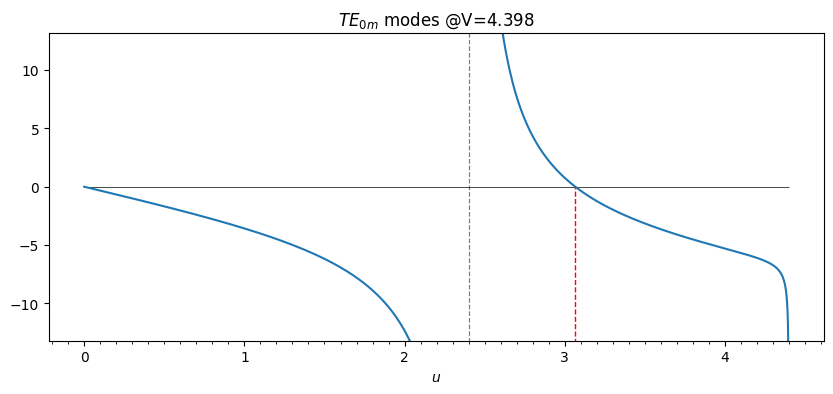

In [18]:
print(f"V = {v:.5f}")
q = 0
print(f"{q = }")

eigen_te = gen_eigen_eq(v, ncore, nclad, q, mode='te')
fig, ax = plot_eigen_eq(eigen_te, v)
plot_diverging_points(ax, v, 0)
roots = get_roots_for_TEM(eigen_te, get_init_points_to_solve_TEM(v), v)
print(f"{roots = }")
plot_roots(ax, roots)
ax.set_title(r"$TE_{0m}$ modes"+f" @V={v:.3f}")

u_te01 = roots[0]
neff_te01 = neff(b(v, u_te01), ncore, nclad)
print(f"neff of TM01: {neff_te01:.6f} (LP11 mode)")

### TM mode test

V = 4.39823
roots = array([3.07293342])
neff of TM01: 1.452322 (LP11 mode)


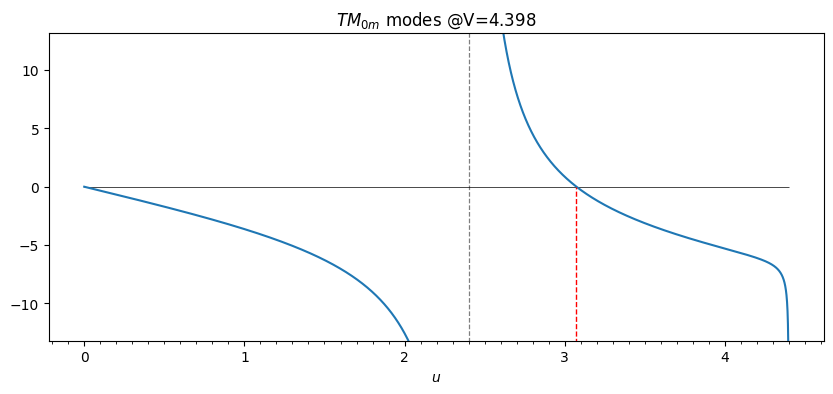

In [19]:
print(f"V = {v:.5f}")

eigen_tm = gen_eigen_eq(v, ncore, nclad, q, mode='tm')
fig, ax = plot_eigen_eq(eigen_tm, v)
plot_diverging_points(ax, v, 0)
roots = get_roots_for_TEM(eigen_tm, get_init_points_to_solve_TEM(v), v)
print(f"{roots = }")
plot_roots(ax, roots)
ax.set_title(r"$TM_{0m}$ modes"+f" @V={v:.3f}")

u_tm01 = roots[0]
neff_tm01 = neff(b(v, u_tm01), ncore, nclad)
print(f"neff of TM01: {neff_tm01:.6f} (LP11 mode)")

### Hybrid mode Test

V = 4.39823
roots = array([[1.94972386],
       [4.03688693],
       [4.22641903]])
neff of HE11: 1.457042 (LP01 mode)
neff of EH11: 1.446567 (LP21 mode)
neff of HE12: 1.445248 (LP02 mode)


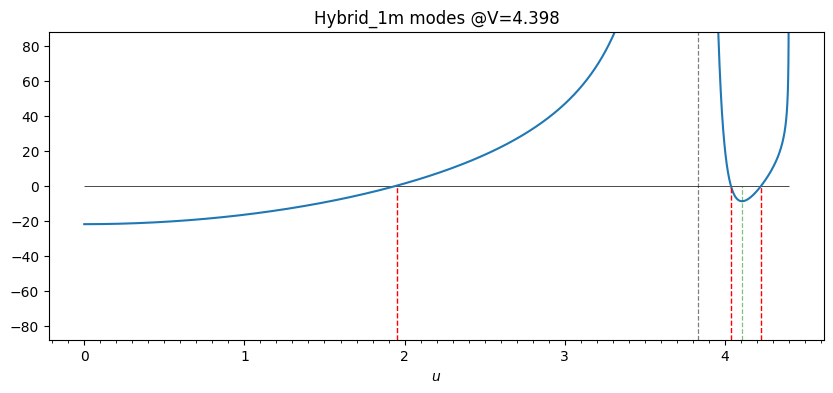

In [20]:
print(f"V = {v:.5f}")
q = 1

eigen_hybrid = gen_eigen_eq(v, ncore, nclad, q, mode='hybrid')
local_minimums = get_local_minimum(eigen_hybrid, v, q)

plot_limit = 20*q*v
fig, ax = plot_eigen_eq(eigen_hybrid, v, plot_limit)
ax.set_title(f"Hybrid_{q}m modes @V={v:.3f}")
plot_diverging_points(ax, v, q, plot_limit)
plot_local_minimum(ax, local_minimums, v, plot_limit)
# ax.set_xlim(v-1E-1, v)
# ax.set_ylim(-1000, 1000)

# roots analysis
roots = get_roots_for_hybrid(eigen_hybrid, v, q)
print(f"{roots = }")
plot_roots(ax, roots, plot_limit)

u_he11 = roots[0][0]
u_eh11 = roots[1][0]
u_he12 = roots[2][0]

neff_he11 = neff(b(v, u_he11), ncore, nclad)
neff_eh11 = neff(b(v, u_eh11), ncore, nclad)
neff_he12 = neff(b(v, u_he12), ncore, nclad)
print(f"neff of HE11: {neff_he11:.6f} (LP01 mode)")
print(f"neff of EH11: {neff_eh11:.6f} (LP21 mode)")
print(f"neff of HE12: {neff_he12:.6f} (LP02 mode)")

V = 4.39823
roots = array([[3.07192247]])
neff of HE21: 1.452327 (LP11 mode)


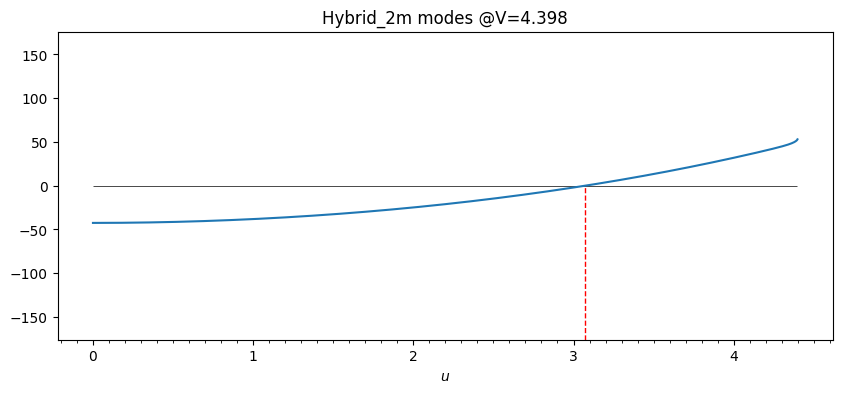

In [21]:
print(f"V = {v:.5f}")
q = 2

eigen_hybrid = gen_eigen_eq(v, ncore, nclad, q, mode='hybrid')
local_minimums = get_local_minimum(eigen_hybrid, v, q)

plot_limit = 20*q*v
fig, ax = plot_eigen_eq(eigen_hybrid, v, plot_limit)
ax.set_title(f"Hybrid_{q}m modes @V={v:.3f}")
plot_diverging_points(ax, v, q, plot_limit)
plot_local_minimum(ax, local_minimums, v, plot_limit)
# ax.set_xlim(v-1E-1, v)
# ax.set_ylim(-1000, 1000)

# roots analysis
roots = get_roots_for_hybrid(eigen_hybrid, v, q)
print(f"{roots = }")
plot_roots(ax, roots, plot_limit)

u_he21 = roots[0][0]

neff_he21 = neff(b(v, u_he21), ncore, nclad)
print(f"neff of HE21: {neff_he21:.6f} (LP11 mode)")

V = 4.39823
roots = array([[4.04335861]])
neff of HE31: 1.446523 (LP11 mode)


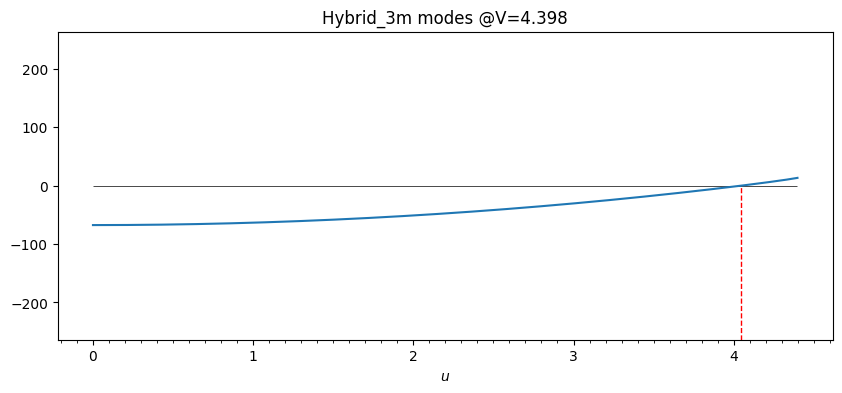

In [22]:
print(f"V = {v:.5f}")
q = 3

eigen_hybrid = gen_eigen_eq(v, ncore, nclad, q, mode='hybrid')
local_minimums = get_local_minimum(eigen_hybrid, v, q)

plot_limit = 20*q*v
fig, ax = plot_eigen_eq(eigen_hybrid, v, plot_limit)
ax.set_title(f"Hybrid_{q}m modes @V={v:.3f}")
plot_diverging_points(ax, v, q, plot_limit)
plot_local_minimum(ax, local_minimums, v, plot_limit)
# ax.set_xlim(v-1E-1, v)
# ax.set_ylim(-1000, 1000)

# roots analysis
roots = get_roots_for_hybrid(eigen_hybrid, v, q)
print(f"{roots = }")
plot_roots(ax, roots, plot_limit)

u_he31 = roots[0][0]

neff_he31 = neff(b(v, u_he31), ncore, nclad)
print(f"neff of HE31: {neff_he31:.6f} (LP11 mode)")

## Beatlength between EH11 and HE31

LP21 모드를 구성하는 두 general mode EH11과 HE31 모드의 beatlength 계산

$$
L_B = \frac{\lambda}{\Delta n}
$$

In [23]:
wavelength = 1.55E-6
delta_n = neff_eh11 - neff_he31

print(f"Beatlength btw. EH11 & HE31: {1000*wavelength/delta_n:.3f} mm")

Beatlength btw. EH11 & HE31: 35.228 mm
